## Replicate temperature profile from Selsis et al., 2023

### Import system packages

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
selsis_data = readdlm("../res/literature_data/profile/OTR10000.txt", Float64; header=false, skipstart=1)
sel_p = selsis_data[:,1]*1.0e-5
sel_t = selsis_data[:,7]
sel_s0 = 35.6
sel_al = 0.18

0.18

In [3]:
F_sun = 1.36e3

1360.0

### Setup AGNI

In [4]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [5]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.dump as dump
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",0)

In [6]:
# Configuration options
instellation    = 50*F_sun   # Stellar flux [W m-2]
gravity         = 9.81
s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_b        = 0.0
radius          = 6.37e6   
nlev_centre     = 40
p_surf          = 270.0         # bar
p_top           = 1e-5      # bar 
mole_fractions  = Dict([("H2O", 1.0)])
condensates     = ["H2O"]
tmp_surf        = 3000.0
thermo          = true

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Oak/318/Oak.sf")
# spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Frostflow/256/Frostflow.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [7]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [8]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        condensates=condensates
                        )
atmosphere.allocate!(atmos, star_file)

In [9]:
fill!(atmos.tmp, atmos.tmp_surf);
fill!(atmos.tmpl, atmos.tmp_surf);

In [10]:
solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         # Conserve energy, but with fixed surface temperature
                                    sens_heat=true,    # Do not include sensible heat transport
                                    latent=true,        # Include condensation
                                    method=1,           # Use the Newton-Raphson method
                                    dx_max=400.0,       # Allow large step sizes because of the poor initial guess
                                    linesearch=true ,   # Enable Linesearch
                                    save_frames=false, modplot=1, # disable plotting 
                                    conv_atol=0.1
                                    )
println("Solver success? $solver_success")

Solver success? true


In [11]:
ins_arr = collect(range(start=50, stop=10, step=-5))
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", length(ins_arr))

for (i,ins) in enumerate(ins_arr)
    @printf("Running model for instellation = %.2e F_sun \n",ins)

    atmos.instellation = F_sun * ins
    
    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=500.0,        # Smaller steps
                                    linesearch=true ,   
                                    save_frames=false, modplot=1,
                                    modprint=0,
                                    conv_atol=0.1  
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))

    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 9 samples... 
Running model for instellation = 5.00e+01 F_sun 
--------------------------------- 
Running model for instellation = 4.50e+01 F_sun 
--------------------------------- 
Running model for instellation = 4.00e+01 F_sun 
--------------------------------- 
Running model for instellation = 3.50e+01 F_sun 
--------------------------------- 
Running model for instellation = 3.00e+01 F_sun 
--------------------------------- 
Running model for instellation = 2.50e+01 F_sun 
--------------------------------- 
Running model for instellation = 2.00e+01 F_sun 
--------------------------------- 
Running model for instellation = 1.50e+01 F_sun 
--------------------------------- 
Running model for instellation = 1.00e+01 F_sun 
--------------------------------- 
Done!


In [12]:
fs=12
lw=1.5
ff="Times New Roman"

"Times New Roman"

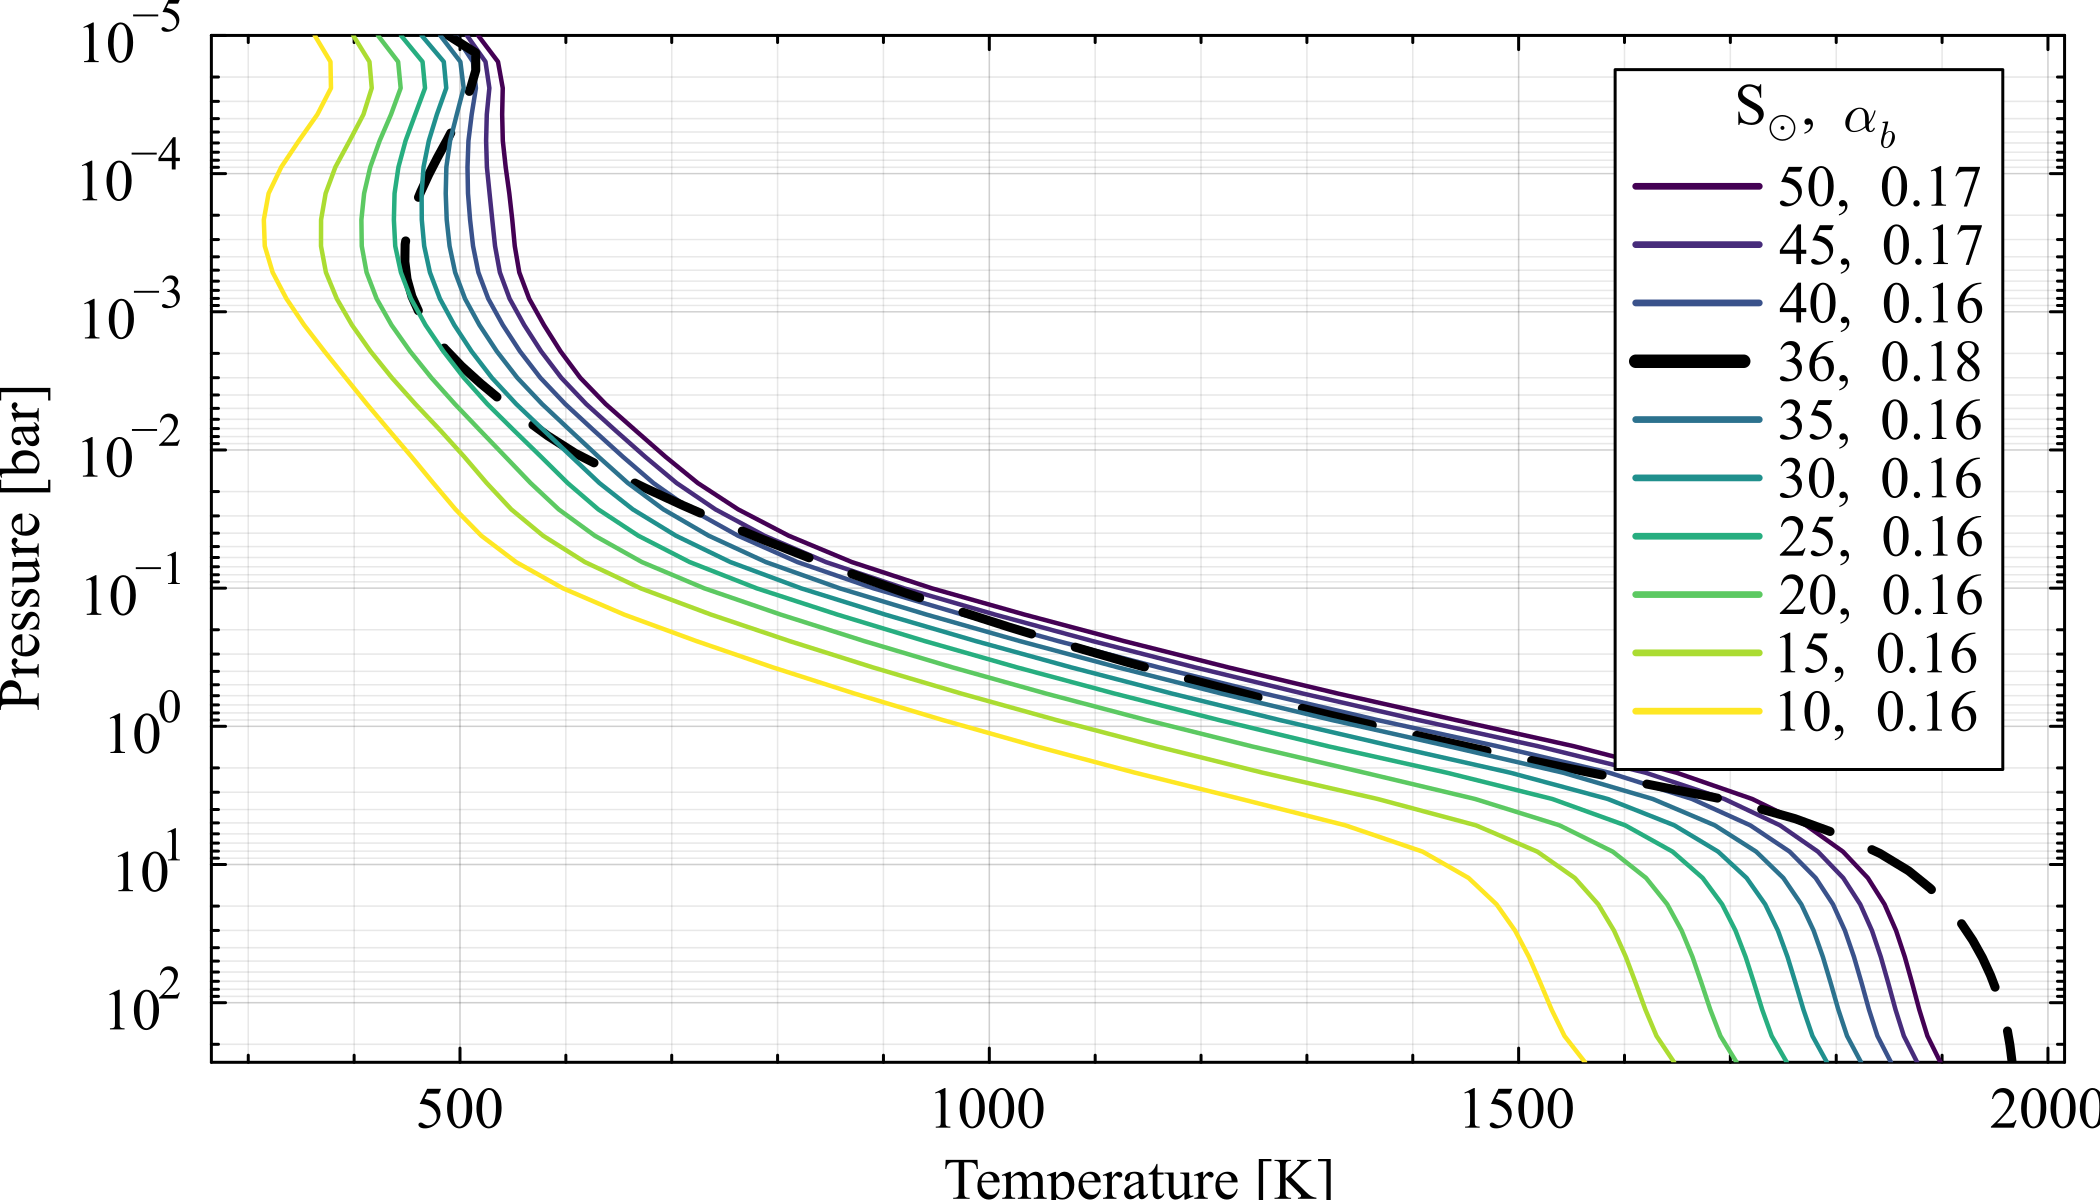

"/Users/nichollsh/Projects/AGNI/out/profiles.pdf"

In [13]:
arr_P = atmos.pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(700,400), dpi=300, 
                leg=:topright, legcolumn=-1,
                tickfontsize=fs, tickfontfamily=ff,
                guidefontsize=fs, guidefontfamily=ff,
                legendfontfamily=ff, legendfontsize=fs, 
                legendtitlefontfamily=ff, legendtitlefontsize=fs,
                leg_title=L"S$_{\odot}$,  $\alpha_b$")
          

p = Plots.palette(:viridis, length(ins_arr))
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%d,  %.2f",this_atm.instellation/F_sun, this_atm.flux_u_sw[1]/this_atm.flux_d_sw[1]))

    if (i < length(ins_arr))
        if (ins_arr[i] < sel_s0 < ins_arr[i+1]) || (ins_arr[i+1] < sel_s0 < ins_arr[i])
            plot!(plt, sel_t, sel_p, lc="black", linestyle=:dash, label=@sprintf("%d,  %.2f", sel_s0, sel_al), linewidth=lw*2.0)
        end 
    end 
end 

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

In [14]:
for (i, atm) in enumerate(atm_arr)
    dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
end